In [30]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

# Simulation parameters
N = 300  # Number of birds
L = 10  # Size of box
R = 3  # Range for observing other birds
r = 1  # Minimum distance to other birds
v_max = 6  # Maximum velocity
lambda_c = 1
lambda_a = 1
lambda_m = 1
dt = 0.1  # Time step
Nt = 80  # Number of time steps
v0 = 0.5  # velocity
Rsq = R**2
eta = 0.01


# Define drone parameters
N_drones = 1
v_d = v_max
x_drones = np.random.rand(N_drones) * L
y_drones = np.random.rand(N_drones) * L
# Change this line where you initialize v_drones
vx_drones = np.zeros(N_drones)*L
vy_drones = np.zeros(N_drones)*L
R_drone = 1.0  # Detection radius for drones
lambda_d = 1

def initialize_birds(N, L):
    '''
    Set initial positions, direction, and velocities 
    '''
    # bird positions
    x = np.random.rand(N, 1) * L
    y = np.random.rand(N, 1) * L
    vx = v0 * np.cos(2 * np.pi * np.random.rand(N, 1))
    vy = v0 * np.sin(2 * np.pi * np.random.rand(N, 1))

    return x, y, vx, vy

def initialize_drones(N, L):
    '''
    Set initial positions and velocities for drones
    '''
    # drone positions
    x = np.random.rand(N, 1) * L
    y = np.random.rand(N, 1) * L

    # drone velocities
    vx = v0 * np.cos(2 * np.pi * np.random.rand(N, 1))
    vy = v0 * np.sin(2 * np.pi * np.random.rand(N, 1))

    return x, y, vx, vy

def apply_boundary_conditions(x, y, L):
    '''
    Apply periodic boundary conditions
    '''
    x = x % L
    y = y % L
    return x, y

def update_positions(x, y, vx, vy, dt, L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    # update positions for all birds simultaneously
    x += vx * dt
    y += vy * dt

    # apply boundary conditions
    x, y = apply_boundary_conditions(x, y, L)

    return x, y

# Initial positions, velocities, and directions
x, y, vx, vy = initialize_birds(N, L)

# Function to find neighbors within range R
def get_local_birds(x, y, i):
    return {j: j for j in range(N) if np.linalg.norm([x[j] - x[i], y[j] - y[i]]) < R and i != j}

# Function to find birds that are too close (within distance r)
def get_too_close_birds(x, y, i):
    return {j: j for j in range(N) if np.linalg.norm([x[j] - x[i], y[j] - y[i]]) < r and i != j}

# Function to limit speed
def limit_speed(vx, vy, v_max):
    speed = np.linalg.norm([vx, vy])
    if speed > v_max:
        vx = (v_max / speed) * vx
        vy = (v_max / speed) * vy     
        print(speed)
    return vx, vy

def update_velocities(x, y, vx_i, vy_i, i, x_drones, y_drones, R_drone):
    local_birds = get_local_birds(x, y, i)
    too_close_birds = get_too_close_birds(x, y, i)

    v_c = lambda_c * (
        (np.sum([x[j] for j in local_birds]) / len(local_birds) - x[i]) if len(local_birds) > 0 else 0,
        (np.sum([y[j] for j in local_birds]) / len(local_birds) - y[i]) if len(local_birds) > 0 else 0
    )

    v_a = lambda_a * (
        (np.sum([x[i] - x[j] for j in too_close_birds]) if len(too_close_birds) > 0 else 0),
        (np.sum([y[i] - y[j] for j in too_close_birds]) if len(too_close_birds) > 0 else 0)
    )

    v_m = lambda_m * (
        (np.sum([vx[j] for j in local_birds]) / len(local_birds) - vx_i) if len(local_birds) > 0 else 0,
        (np.sum([vy[j] for j in local_birds]) / len(local_birds) - vy_i) if len(local_birds) > 0 else 0
    )

    vx_i_new = vx_i + v_c[0] + v_a[0] + v_m[0] 
    vy_i_new = vy_i + v_c[1] + v_a[1] + v_m[1] 

    # Limit speed
    vx_i_new, vy_i_new = limit_speed(vx_i_new, vy_i_new, v_max)

    # Check if the bird is within the observation range of any drone
    for d in range(N_drones):
        distance_to_drone = np.linalg.norm([x[i] - x_drones[d, 0], y[i] - y_drones[d, 0]])
        if distance_to_drone < R_drone:
            # Birds within R_drone experience a negative velocity
            vx_i_new, vy_i_new = -vx_i_new, -vy_i_new
            break
    return vx_i_new, vy_i_new

# Function to update quiver plot data
def update_quiver(quiver, x, y, vx, vy):
    quiver.set_UVC(vx, vy)
    quiver.set_offsets(np.column_stack([x, y]))
    return quiver

# Function to update scatter plot data for drones
def update_drones(scatter, x, y):
    scatter.set_offsets(np.column_stack([x, y]))
    return scatter


def step(x, y, vx, vy, N, dt, L, x_drones, y_drones, R_drone, vx_drones, vy_drones):
    # Update positions and velocities for birds
    for i in range(N):
        x, y = update_positions(x, y, vx, vy, dt, L)
        vx[i], vy[i] = update_velocities(x, y, vx[i], vy[i], i, x_drones, y_drones, R_drone)

        # Calculate new positions and velocities for drones towards the center of mass
    center_of_mass = np.mean(np.column_stack((x, y)), axis=0)
    # print("centre of mass", center_of_mass)
    for i in range(N_drones):
        drone_pos = np.array([x_drones[i], y_drones[i]])
        # print("array of x_d and y_d", drone_pos[0])
        direction = center_of_mass - drone_pos[0]

        # print("direction", direction)
        #direction /= np.linalg.norm(direction)
        # print("normalized", direction)
        vx_drones[i] = lambda_d * direction[0]
        vy_drones[i] = lambda_d * direction[1]

        # Update positions for drones
        x_drones[i] += vx_drones[i] * dt
        y_drones[i] += vy_drones[i] * dt


    x_drones, y_drones = apply_boundary_conditions(x_drones, y_drones, L)

            
    return x, y, vx, vy, x_drones, y_drones, vx_drones, vy_drones



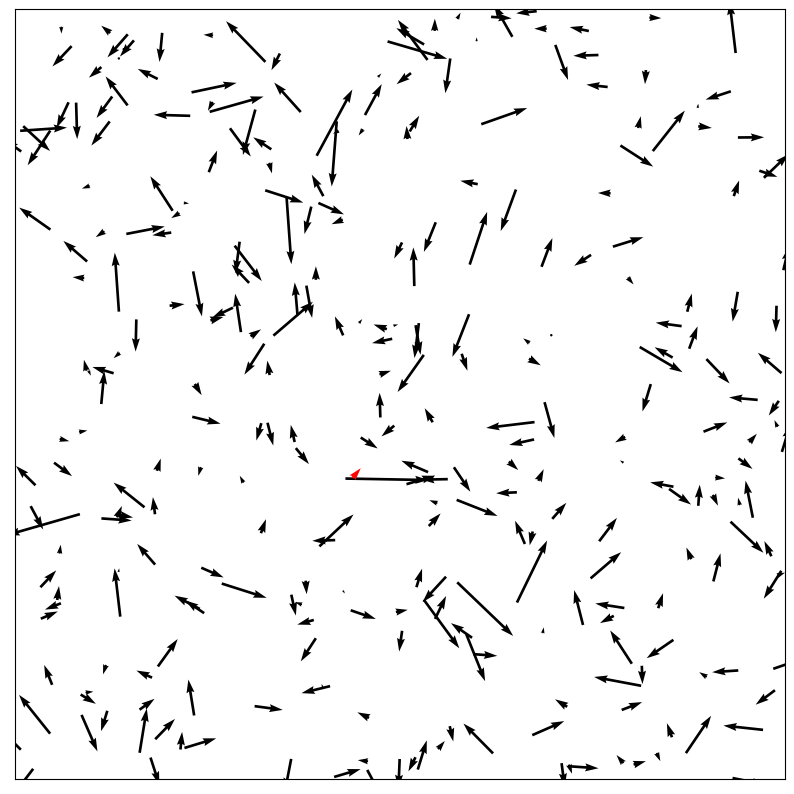

KeyboardInterrupt: 

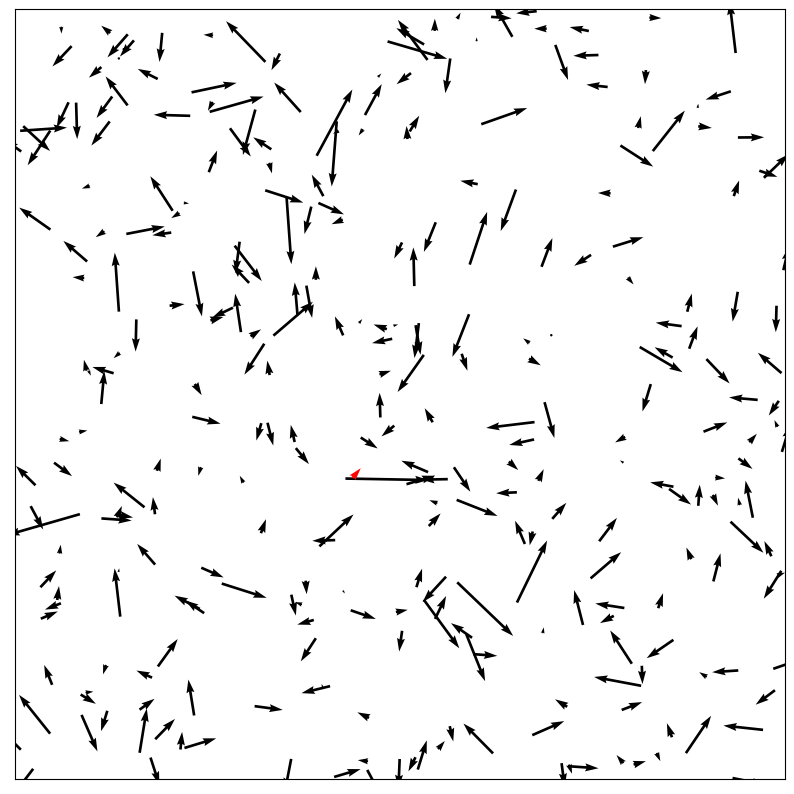

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Assuming initialization of birds and drones
x_birds, y_birds, vx_birds, vy_birds = initialize_birds(N, L)
x_drones, y_drones, vx_drones, vy_drones = initialize_drones(N_drones, L)


# Assuming initialization of quiver and scatter plots
birds_quiver = ax.quiver(x_birds, y_birds, vx_birds, vy_birds, color='black')
drones_quiver = ax.quiver(x_drones, y_drones, vx_drones, vy_drones, color='red')


ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# do each step, updating the quiver and scatter plots
for iT in range(Nt):
    x_birds, y_birds, vx_birds, vy_birds, x_drones, y_drones, vx_drones, vy_drones = step(x_birds, y_birds, vx_birds, vy_birds, N, dt, L, x_drones, y_drones, R_drone, vx_drones, vy_drones)
    birds_quiver = update_quiver(birds_quiver, x_birds, y_birds, vx_birds, vy_birds)
    drones_quiver = update_quiver(drones_quiver, x_drones, y_drones, vx_drones, vy_drones)
    clear_output(wait=True)
    display(fig)

[29.63317946  6.91362894 10.67493934 20.3262578 ] [1.30653906e+00 3.22591639e+01 8.44009383e+01 4.51211728e-02]


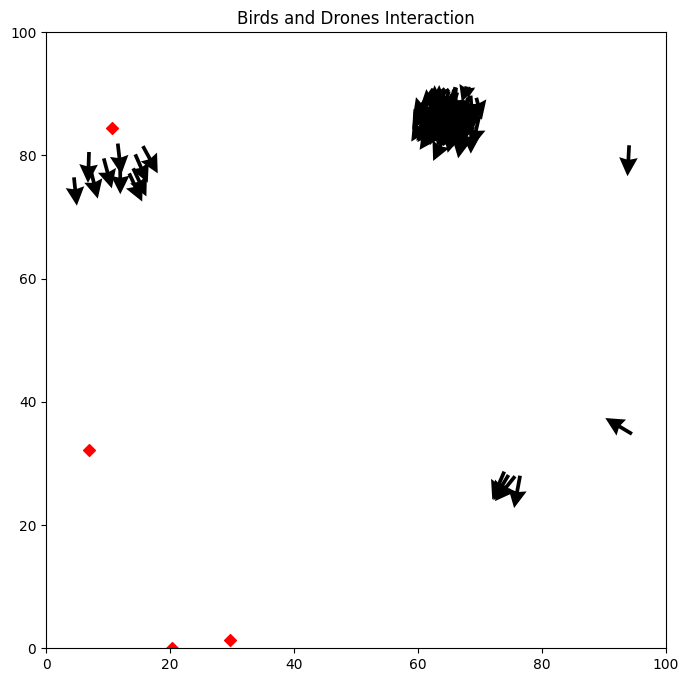

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Parameters for the Vicsek model
N = 100  # number of birds
L = 100  # size of the domain

eta = 0.5  # noise
v = 10  # velocity of birds
dt = 0.5   # time step
R = 5     # radius of interaction
Nt = 150  # number of time steps
Rsq = R**2
r = 1 #minimum distance between birds
# Parameters for drones
Nd = 4  # number of drones
vd = 12  # constant speed of drones
Rd = 7  # range of influence of drones




# Initialize birds
def initialize_birds(N, L):
    x = np.random.rand(N) * L
    y = np.random.rand(N) * L
    theta = np.random.rand(N) * 2 * np.pi
    vx = v * np.cos(theta)
    vy = v * np.sin(theta)
    return x, y, vx, vy, theta

# Initialize drones
def initialize_drones(Nd, L):
    x = np.random.rand(Nd) * L
    y = np.random.rand(Nd) * L
    theta = np.random.rand(Nd) * 2 * np.pi
    vx = vd * np.cos(theta)
    vy = vd * np.sin(theta)
    return x, y, vx, vy

# Vicsek model update for birds
def update(x, y, vx, vy, theta, Rsq, eta, N, dt, r, drone_x, drone_y, Rd):
    for i in range(N):
        # Calculate distance to each bird
        dx = x - x[i]
        dy = y - y[i]
        dist_sq = dx**2 + dy**2

        # Identify neighbors within the interaction radius
        within_radius = dist_sq < Rsq

        # Avoidance rule to keep minimum distance
        avoid_collisions = np.zeros(2)
        for j in range(N):
            if i != j and dist_sq[j] < r**2:
                avoid_collisions += r / (np.sqrt(dist_sq[j]) + 1e-5) * np.array([x[i] - x[j], y[i] - y[j]])

        # Dispersal rule when a drone is in the radius
        dx_drone = x[i] - drone_x
        dy_drone = y[i] - drone_y
        dist_sq_drone = dx_drone**2 + dy_drone**2
        within_radius_drone = dist_sq_drone < Rd**2
        v_c = np.zeros(2)
        if np.any(within_radius_drone):
            # Move away from the drone's position
            #theta[i] = np.arctan2(dy_drone.mean(), dx_drone.mean()) + eta * (np.random.rand() - 0.5)
            theta[i] = np.arctan2(-vy[i], -vx[i])
        elif np.sum(within_radius) > 0:
            center_of_mass = np.array([np.sum(x[within_radius]) / np.sum(within_radius),
                                       np.sum(y[within_radius]) / np.sum(within_radius)])
            v_c = center_of_mass - np.array([x[i], y[i]])
        # Vicsek model update
        theta[i] = np.arctan2(vy[within_radius].mean(), vx[within_radius].mean()) + eta * (np.random.rand() - 0.5)

        # Update velocity
        vx[i] = v * np.cos(theta[i]) + v_c[0] + avoid_collisions[0]
        vy[i] = v * np.sin(theta[i]) + v_c[1] + avoid_collisions[1]

    # Update positions
    x += vx * dt
    y += vy * dt

    # Apply periodic boundary conditions
    x = x % L
    y = y % L

    return x, y, vx, vy

def update_drones(drone_x, drone_y, drone_vx, drone_vy, x, y, L, vd, dt, Rd):
    # Move drones towards the direction with the most birds in their radius
    for i in range(Nd):
        # Calculate distance to each bird
        dx_to_bird = x - drone_x[i]
        dy_to_bird = y - drone_y[i]
        dist_sq = dx_to_bird**2 + dy_to_bird**2

        # Identify birds within the drone's range
        within_radius = dist_sq < Rd**2
        N_birds_in_radius = np.sum(within_radius)

        # Find the centroid of birds within the drone's range
        if N_birds_in_radius > 0:
            centroid = np.array([np.sum(x[within_radius]) / N_birds_in_radius, np.sum(y[within_radius]) / N_birds_in_radius])
            # Calculate direction vector towards the centroid
            direction_to_centroid = centroid - np.array([drone_x[i], drone_y[i]])
            # Normalize the direction vector
            direction_to_centroid /= np.linalg.norm(direction_to_centroid)
            # Adjust drone's velocity towards the centroid
            drone_vx[i] = vd * direction_to_centroid[0]
            drone_vy[i] = vd * direction_to_centroid[1]
        else:
            # If no birds are in radius, move straight ahead
            drone_vx[i] = vd
            drone_vy[i] = 0

        # Move drones straight ahead
        drone_x[i] += drone_vx[i] * dt
        drone_y[i] += drone_vy[i] * dt

        # Apply periodic boundary conditions
        drone_x[i] = drone_x[i] % L
        drone_y[i] = drone_y[i] % L

    return drone_x, drone_y, drone_vx, drone_vy

# Visualization function
def visualize(x, y, vx, vy, drone_x, drone_y):
    plt.figure(figsize=(8, 8))

    # Plot birds as smaller arrows
    plt.quiver(x, y, vx, vy, color='black', scale=200, headwidth=5, headlength=5)

    # Plot drones as red diamonds
    plt.scatter(drone_x, drone_y, c='red', marker='D', label='Drones')

    plt.xlim(0, L)
    plt.ylim(0, L)
    plt.title("Birds and Drones Interaction")
    plt.show()


# Simulation
x, y, vx, vy, theta = initialize_birds(N, L)
drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

for _ in range(Nt):
    drone_x, drone_y, drone_vx, drone_vy = update_drones(drone_x, drone_y, drone_vx, drone_vy, x, y, L, vd, dt, Rd)
    print(drone_x, drone_y)
    x, y, vx, vy = update(x, y, vx, vy, theta, Rsq, eta, N, dt, r, drone_x, drone_y, Rd)
    visualize(x, y, vx, vy, drone_x, drone_y)
    clear_output(wait=True)
